In [1]:
import cv2
import numpy as np
import pandas as pd
import lightgbm as lgb
import imutils
from os import listdir
from matplotlib import pyplot as plt
from imutils import contours
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
img_width = 400
img_height = 400

In [3]:
def zca_whitening(x):
    flat_x = x.flatten(order='F')
    flat_x = flat_x.reshape(1, len(flat_x))
    
    # Calculate principal components
    sigma = np.dot(flat_x, flat_x.T) / flat_x.shape[0]
    u, s, v = np.linalg.svd(sigma)
    principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + 10e-7))), u.T)

    # Apply ZCA whitening
    whitex = np.dot(principal_components, flat_x)
    
    # Transform back to matrix
    whitex = np.uint8(whitex.reshape(x.shape[0], x.shape[1]))
    
    # Rotation
    whitex = np.rot90(whitex, 3)
    
    # Adaptative equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(whitex)
    
    return cl1

In [4]:
def sift_and_show(x):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(x, None)
    img = cv2.drawKeypoints(x, kp, None)
    plt.imshow(img)

In [5]:
def sift(x):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(x, None)
    return des

In [6]:
#https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/
def shape_detect(x):
    # convert the resized image to grayscale, blur it slightly,
    # and threshold it
    gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

    # find contours in the thresholded image and initialize the
    # shape detector
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [7]:
def apply_filters(x):
    gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    kernel = np.ones((6,6), np.uint8)
    gradient = cv2.morphologyEx(blurred, cv2.MORPH_GRADIENT, kernel)
    return gradient

In [8]:
class SiftTransformer(BaseEstimator, TransformerMixin):
    """Init SIFT transformer
    
    Parameters
    -----------
    nfeatures:          The number of best features to retain. The features are ranked by their scores (measured 
                        in SIFT algorithm as the local contrast)
                        
    nOctaveLayers:      The number of layers in each octave. 3 is the value used in D. 
                        Lowe paper. The number of octaves is computed automatically from the image resolution.
                        
    contrastThreshold:  The contrast threshold used to filter out weak features in semi-uniform (low-contrast) 
                        regions. The larger the threshold, the less features are produced by the detector.
                        
    edgeThreshold:      The threshold used to filter out edge-like features. Note that the its meaning is 
                        different from the contrastThreshold, i.e. the larger the edgeThreshold, the less 
                        features are filtered out (more features are retained).

    sigma:              The sigma of the Gaussian applied to the input image at the octave #0. If your image 
                        is captured with a weak camera with soft lenses, you might want to reduce the number. 
    """
    def __init__(self, 
                 nfeatures = 0,
                 nOctaveLayers = 3, 
                 contrastThreshold = 0.04, 
                 edgeThreshold = 10, 
                 sigma = 1.6):
        self.nfeatures = nfeatures
        self.nOctaveLayers = nOctaveLayers
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        self.sigma = sigma
        
    def fit(self, X, y = None):
        return self
    
    #return a matrix of SIFT descriptors
    def transform(self, X, y = None):
        sift = cv2.xfeatures2d.SIFT_create(self.nfeatures,
                                           self.nOctaveLayers,
                                           self.contrastThreshold,
                                           self.edgeThreshold,
                                           self.sigma)
        ret = []
        for x in X:
            kp, des = sift.detectAndCompute(x, None)
            if des is None:
                continue
            else:
                ret.append(des)
            
        return ret

In [9]:
class KMeansTransformerV1(BaseEstimator, TransformerMixin):
    """Init KMeans transformer v1
    
    Parameters
    -----------
    n_clusters:         The number of clusters
    """       
    def __init__(self, n_clusters = 0):
        self.kmeans = []
        self.n_clusters = n_clusters
            
    def fit(self, X, y = None):
        for i in range(0, len(X)):
            self.kmeans.append(KMeans(n_clusters=self.n_clusters))
            self.kmeans[i].fit(X[i])
            
        return self
    
    #return a Matrix where each line vector contains number of keypoints per cluster
    def transform(self, X, y = None):
        ret = []
        for i in range(0, len(X)):
            y_pred = self.kmeans[i].predict(X[i])
            agg = []
            for j in range(0, self.n_clusters):
                agg.append(len([c for c in y_pred if c == j]))
            
            ret.append(agg)
            
        return ret
    
    def to_string(self):
        return "kmeans-v1"

In [10]:
class KMeansTransformerV2(BaseEstimator, TransformerMixin):
    """Init KMeans transformer v2
    
    Parameters
    -----------
    n_clusters:         The number of clusters
    """       
    def __init__(self, max_keypoints, n_clusters = 0):
        self.kmeans = KMeans()
        self.n_clusters = n_clusters
        self.max_keypoints = max_keypoints
        self.scaler = StandardScaler()
    
    #fit the KMeans on the maximum possible matrix
    def fit(self, X, y = None):
        X_tmp = []
        
        for i in range(0, len(X)):
            X_tmp.append(X[i].reshape(-1, 1))
        
        X_out = []
        for i in range(0, len(X)):
            X_out.append([a[0] for a in X_tmp[i][0:self.max_keypoints]])
        
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.kmeans.fit(X_out)
        
        return self
    
    #return a Matrix where each line vector contains number of keypoints per cluster
    def transform(self, X, y = None):
        X_tmp = []
        
        for i in range(0, len(X)):
            X_tmp.append(X[i].reshape(-1, 1))
        
        X_out = []
        for i in range(0, len(X)):
            X_out.append([a[0] for a in X_tmp[i][0:self.max_keypoints]])
        
        tmp = self.kmeans.transform(X_out)
        self.scaler.fit(tmp)
        
        return self.scaler.transform(tmp)
    
    def to_string(self):
        return "kmeans-v2"

In [11]:
class LGBModelEstimator(BaseEstimator):
    def __init__(self,
                 learning_rate = 0.1,
                 objective = 'multiclass',
                 metric = 'multi_logloss',
                 num_class = 3,
                 num_trees = 25,
                 num_leaves = 10,
                 max_depth = 3):
        
        self.learning_rate = learning_rate
        self.objective = objective
        self.metric = metric
        self.num_class = num_class
        self.num_trees = num_trees
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.lgbm = lgb.LGBMModel()
        
    def fit(self, X, y = None):
        self.lgbm = lgb.LGBMModel(learning_rate=self.learning_rate,
                                  objective=self.objective,
                                  metric=self.metric,
                                  num_class=self.num_class,
                                  num_trees=self.num_trees,
                                  num_leaves=self.num_leaves,
                                  max_depth=self.max_depth)
        self.lgbm.fit(X,y)
        return self
    
    def predict(self, X, y = None):
        tmp = self.lgbm.predict(X)
        return tmp.argmax(axis=-1)
    
    def score(self, X, y = None):
        return accuracy_score(self.predict(X), y)

# Import des données

In [12]:
path = "Images/"

In [13]:
y = []
X = []
for dogType in listdir(path):
    for img in listdir(path + dogType):
        y += [dogType]
        X += [cv2.imread(path + dogType + '/' + img)]

In [14]:
for i in range(0, len(X)):
    X[i] = cv2.resize(X[i], (img_width, img_height))

In [15]:
X_filtered = []
for i in range(0, len(X)):
    X_filtered.append(apply_filters(X[i]))

In [16]:
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

# Filtres

In [125]:
gray = cv2.cvtColor(X[0], cv2.COLOR_BGR2GRAY)

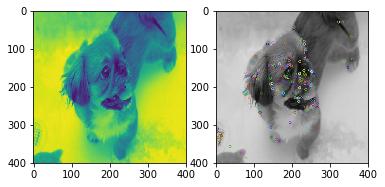

In [126]:
sift_and_show(gray)

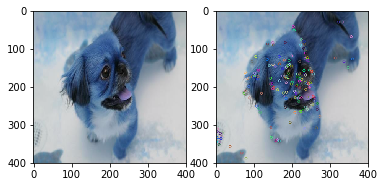

In [127]:
sift_and_show(X[0])

In [128]:
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(X[0],-1,kernel)

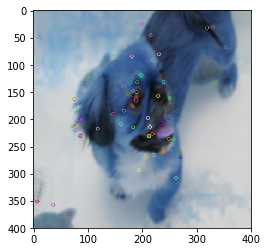

In [13]:
sift_and_show(dst)

In [14]:
dst = cv2.filter2D(gray,-1,kernel)

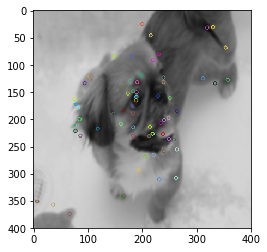

In [15]:
sift_and_show(dst)

In [16]:
zca = zca_whitening(gray)

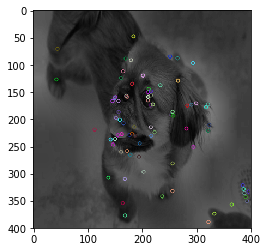

In [17]:
sift_and_show(zca)

In [31]:
# convert the resized image to grayscale, blur it slightly,
# and threshold it
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

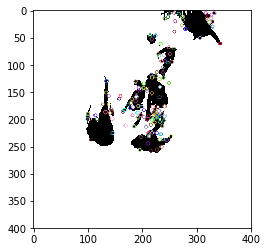

In [32]:
sift_and_show(thresh)

In [52]:
kernel = np.ones((6,6),np.uint8)
erosion = cv2.erode(X[0],kernel,iterations = 1)

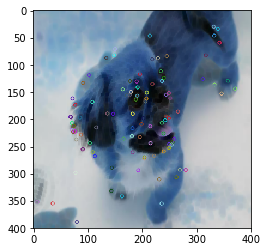

In [34]:
sift_and_show(erosion)

In [62]:
dilation = cv2.dilate(X[0],kernel,iterations = 1)

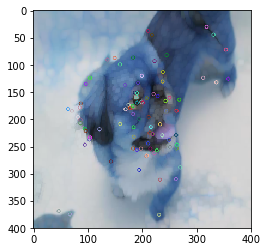

In [63]:
sift_and_show(dilation)

In [37]:
opening = cv2.morphologyEx(X[0], cv2.MORPH_OPEN, kernel)

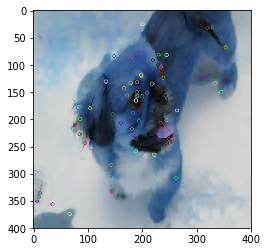

In [38]:
sift_and_show(opening)

In [64]:
gradient = cv2.morphologyEx(dilation, cv2.MORPH_GRADIENT, kernel) #6x6

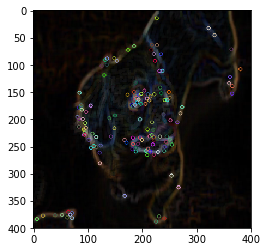

In [65]:
sift_and_show(gradient)

In [41]:
tophat = cv2.morphologyEx(blurred, cv2.MORPH_TOPHAT, kernel) #9x9

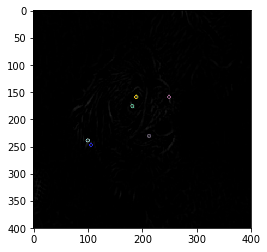

In [42]:
sift_and_show(tophat)

In [43]:
blackhat = cv2.morphologyEx(X[0], cv2.MORPH_BLACKHAT, kernel)

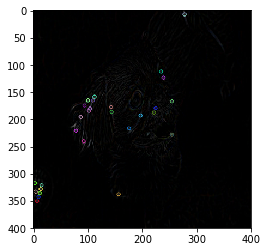

In [44]:
sift_and_show(blackhat)

In [48]:
shape_detect(X[0])

[array([[[289,   0]],
 
        [[289,   5]],
 
        [[290,   4]],
 
        [[290,   2]],
 
        [[289,   1]]], dtype=int32), array([[[278,   0]],
 
        [[278,   1]],
 
        [[279,   2]],
 
        [[279,   4]],
 
        [[280,   5]],
 
        [[280,   7]],
 
        [[281,   8]],
 
        [[281,   9]],
 
        [[282,  10]],
 
        [[282,  11]],
 
        [[282,   0]]], dtype=int32), array([[[  0,   0]],
 
        [[  0, 399]],
 
        [[399, 399]],
 
        [[399,   0]],
 
        [[309,   0]],
 
        [[309,   1]],
 
        [[314,   6]],
 
        [[315,   6]],
 
        [[316,   7]],
 
        [[317,   7]],
 
        [[318,   6]],
 
        [[319,   6]],
 
        [[320,   5]],
 
        [[321,   5]],
 
        [[322,   6]],
 
        [[323,   6]],
 
        [[324,   7]],
 
        [[324,   8]],
 
        [[325,   9]],
 
        [[325,  12]],
 
        [[324,  13]],
 
        [[324,  14]],
 
        [[323,  15]],
 
        [[320,  15]],
 
        [[319,  

# II Filtres choisis

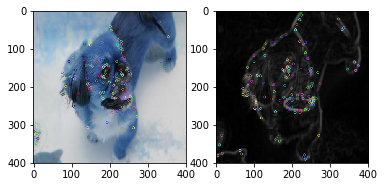

In [11]:
i = 0
plt.subplot(121)
sift_and_show(X[i])
img = apply_filters(X[i])
plt.subplot(122)
sift_and_show(img)

# Classification - Training

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.30, random_state=42)

In [309]:
clusters = [KMeansTransformerV1(), KMeansTransformerV2(max_keypoints=3456)]
n_clusters = [10, 20, 30]
nOctaveLayers = [3, 4, 5]
learning_rate = [0.01, 0.1, 0.3]

In [320]:
results = []
for kmeans in clusters:
    for n in n_clusters:
        kmeans.set_params(**{'n_clusters':n})
        for n_layers in nOctaveLayers:
            sift = SiftTransformer(nOctaveLayers=n_layers)
            for a in learning_rate:
                lgbm = lgb.LGBMModel(objective='multiclass',
                                    metric='multi_logloss',
                                    num_class=max(y_encoded)+1,
                                    n_estimators=25,
                                    num_leaves=10,
                                    max_depth=3,
                                    learning_rate=a)
                pipe = Pipeline([
                                    ('sift', sift),
                                    ('cluster', kmeans),
                                    ('classify', lgbm)
                                ])
                
                pipe.fit(X_train, y_train)
                y_pred_train = pipe.predict(X_train).argmax(axis=-1)
                y_pred_test = pipe.predict(X_test).argmax(axis=-1)
                
                tmp = {
                    'cluster': kmeans.to_string(),
                    'n_cluster': n,
                    'nOctaveLayers': n_layers,
                    'learning_rate': a,
                    'train_accuracy': accuracy_score(y_pred_train, y_train),
                    'test_accuracy': accuracy_score(y_pred_test, y_test)
                }
                results.append(tmp)

/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning

/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning

In [412]:
def results_graph(xabs, xabs_legend, vbar, yord_legend, mean_scores):
    bar_offsets = (np.arange(len(xabs)) * (len(vbar) + 1) + .5)
    COLORS = 'bgrcmyk'
    for i, (label, score) in enumerate(zip(vbar, mean_scores)):
        plt.bar(bar_offsets + i, score, label=label, color=COLORS[i])

    plt.xlabel(xabs_legend)
    plt.xticks(bar_offsets + len(vbar) / 2, xabs)
    plt.ylabel(yord_legend)
    plt.ylim((0.0, 1.1 * max(max(mean_scores))))
    plt.legend(loc='upper right')

    plt.show()

In [390]:
def mean_score(results, groups):
    tmp = results.groupby(groups)
    train = []
    test = []
    for g1 in list(set(results.loc[:, groups[0]])):
        train_sub = []
        test_sub = []
        for g2 in list(set(results.loc[:, groups[1]])):
            tmp2 = tmp.get_group((g1,g2)).agg(np.mean)
            train_sub.append(tmp2.train_accuracy)
            test_sub.append(tmp2.test_accuracy)
            
        train.append(train_sub)
        test.append(test_sub)
    return train, test

In [324]:
df = pd.DataFrame(results)
df.to_csv('results.csv')

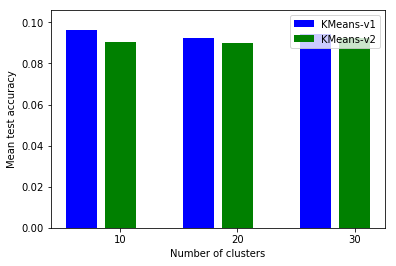

In [420]:
r1, r2 = mean_score(df, ['cluster', 'n_cluster'])
results_graph(n_clusters, 'Number of clusters', ['KMeans-v1', 'KMeans-v2'], 'Mean test accuracy', r2)

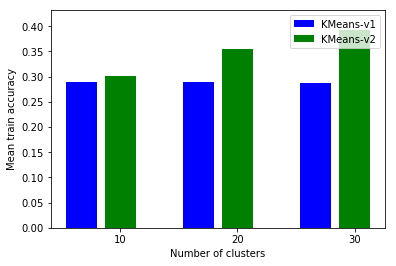

In [421]:
results_graph(n_clusters, 'Number of clusters', ['KMeans-v1', 'KMeans-v2'], 'Mean train accuracy', r1)

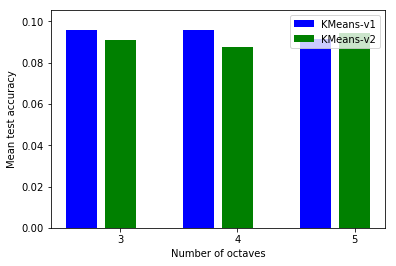

In [427]:
r1, r2 = mean_score(df, ['cluster', 'nOctaveLayers'])
results_graph(nOctaveLayers, 'Number of octaves', ['KMeans-v1', 'KMeans-v2'], 'Mean test accuracy', r2)

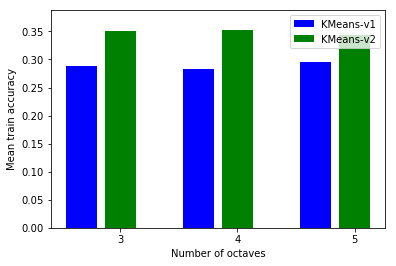

In [428]:
results_graph(nOctaveLayers, 'Number of octaves', ['KMeans-v1', 'KMeans-v2'], 'Mean train accuracy', r1)

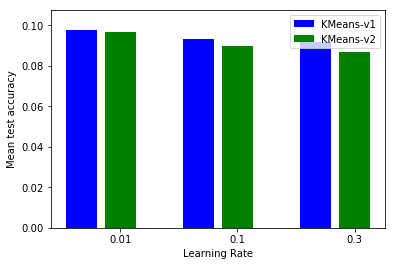

In [425]:
r1, r2 = mean_score(df, ['cluster', 'learning_rate'])
results_graph(learning_rate, 'Learning Rate', ['KMeans-v1', 'KMeans-v2'], 'Mean test accuracy', r2)

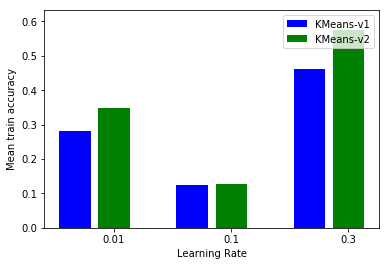

In [426]:
results_graph(learning_rate, 'Learning Rate', ['KMeans-v1', 'KMeans-v2'], 'Mean train accuracy', r1)

In [352]:
df

cluster  learning_rate  nOctaveLayers  n_cluster  test_accuracy  \
0   kmeans-v1           0.01              3         10       0.091954   
1   kmeans-v1           0.10              3         10       0.104725   
2   kmeans-v1           0.30              3         10       0.097063   
3   kmeans-v1           0.01              4         10       0.093231   
4   kmeans-v1           0.10              4         10       0.097063   
5   kmeans-v1           0.30              4         10       0.090677   
6   kmeans-v1           0.01              5         10       0.093231   
7   kmeans-v1           0.10              5         10       0.089400   
8   kmeans-v1           0.30              5         10       0.108557   
9   kmeans-v1           0.01              3         20       0.090677   
10  kmeans-v1           0.10              3         20       0.095785   
11  kmeans-v1           0.30              3         20       0.100894   
12  kmeans-v1           0.01              4         20       0.094508   
13  kmeans-v1           0.10              4         20       0.106003   
14  kmeans-v1           0.30              4         20       0.091954   
15  kmeans-v1           0.01              5         20       0.090677   
16  kmeans-v1           0.10              5         20       0.081737   
17  kmeans-v1           0.30              5         20       0.077905   
18  kmeans-v1           0.01              3         30       0.095785   
19  kmeans-v1           0.10              3         30       0.104725   
20  kmeans-v1           0.30              3         30       0.080460   
21  kmeans-v1           0.01              4         30       0.097063   
22  kmeans-v1           0.10              4         30       0.094508   
23  kmeans-v1           0.30              4         30       0.097063   
24  kmeans-v1           0.01              5         30       0.093231   
25  kmeans-v1           0.10              5         30       0.104725   
26  kmeans-v1           0.30              5         30       0.081737   
27  kmeans-v2           0.01              3         10       0.085568   
28  kmeans-v2           0.10              3         10       0.103448   
29  kmeans-v2           0.30              3         10       0.080460   
30  kmeans-v2           0.01              4         10       0.085568   
31  kmeans-v2           0.10              4         10       0.090677   
32  kmeans-v2           0.30              4         10       0.085568   
33  kmeans-v2           0.01              5         10       0.094508   
34  kmeans-v2           0.10              5         10       0.090677   
35  kmeans-v2           0.30              5         10       0.098340   
36  kmeans-v2           0.01              3         20       0.088123   
37  kmeans-v2           0.10              3         20       0.093231   
38  kmeans-v2           0.30              3         20       0.076628   
39  kmeans-v2           0.01              4         20       0.089400   
40  kmeans-v2           0.10              4         20       0.099617   
41  kmeans-v2           0.30              4         20       0.086845   
42  kmeans-v2           0.01              5         20       0.086845   
43  kmeans-v2           0.10              5         20       0.099617   
44  kmeans-v2           0.30              5         20       0.090677   
45  kmeans-v2           0.01              3         30       0.093231   
46  kmeans-v2           0.10              3         30       0.106003   
47  kmeans-v2           0.30              3         30       0.090677   
48  kmeans-v2           0.01              4         30       0.089400   
49  kmeans-v2           0.10              4         30       0.093231   
50  kmeans-v2           0.30              4         30       0.070243   
51  kmeans-v2           0.01              5         30       0.094508   
52  kmeans-v2           0.10              5         30       0.094508   
53  kmeans-v2           0.30              5         30       0.1

# Classification - Testing

In [21]:
pipe = Pipeline([
    ('sift', SiftTransformer(nOctaveLayers=5)),
    ('cluster', KMeansTransformerV1(n_clusters=30)),
    ('classify', lgb.LGBMModel(objective='multiclass',
                               metric='multi_logloss',
                               num_class=max(y_encoded)+1,
                               num_trees=25,
                               num_leaves=10,
                               max_depth=3,
                               learning_rate=0.30))
])

In [22]:
pipe.fit(X_train, y_train)

/home/jct/.local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Pipeline(memory=None,
     steps=[('sift', SiftTransformer(contrastThreshold=0.04, edgeThreshold=10, nOctaveLayers=5,
        nfeatures=0, sigma=1.6)), ('cluster', KMeansTransformerV1(n_clusters=30)), ('classify', LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
     importance_type='split', learning_r...=0.0, reg_lambda=0.0, silent=True,
     subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [23]:
y_pred_train = pipe.predict(X_train)
y_pred_train.argmax(axis=-1)

array([14,  2,  8, ...,  9,  7,  2])

In [24]:
y_train

array([14,  0,  8, ...,  9,  7,  2])

In [25]:
y_pred_test = pipe.predict(X_test)
y_pred_test.argmax(axis=-1)

array([10,  2,  8, 13, 12,  9,  8,  6,  1, 10,  6,  6,  9, 14,  2, 13,  2,
       12,  9,  2,  2, 14,  5,  2,  1,  6,  6,  3,  6,  4,  9, 14, 10,  6,
       12,  1,  0, 10,  2, 14,  2, 14, 14, 12,  0,  0, 12,  4,  4,  7, 11,
       13, 11, 13,  7,  3,  9, 13, 13, 11,  8,  6,  4,  9,  4,  2,  4,  8,
        4,  4,  6,  9,  9,  4,  6,  5,  8,  4,  9, 10, 12,  2, 14,  8, 11,
        7,  2,  3,  6,  4, 13, 10,  2,  3,  6,  9,  5,  9,  4,  5, 14,  3,
        6, 13, 11, 10, 10,  2, 14,  9, 10,  9,  2,  1,  8, 12,  0,  5,  4,
        2,  4,  3,  2,  1, 12,  1,  2,  9,  4,  3,  9, 12,  8,  7,  2,  0,
        3, 13,  1, 13, 12,  9, 13,  3,  2, 11,  4, 11, 11,  2,  2,  1, 12,
        2, 12, 14,  1, 14,  0,  2,  2,  0,  1,  4, 10,  0,  4,  5,  0,  9,
        7,  9,  2,  4,  2,  4,  2,  2,  0, 12,  2, 14,  4,  1,  8,  1,  1,
        3,  1, 11,  6,  2,  1,  5, 12,  6, 13,  7,  2, 10,  4, 12, 12, 11,
        1, 12, 12, 10,  2,  3, 11,  7,  2,  9, 10,  1, 14,  3,  2, 13,  0,
       10,  6,  9,  2,  8

In [26]:
y_test

array([ 2,  2,  1, 12,  8,  6,  2, 10, 10, 10, 13,  3,  1, 12, 14,  7,  2,
       13,  8,  3,  7,  5,  7, 13,  7, 10,  8,  4, 10,  8,  9,  5,  7,  8,
        2, 11,  4,  6,  4,  9,  1, 14,  3, 14,  3,  8,  6, 11,  7,  7,  4,
        5,  2,  1, 11,  9, 11,  1, 14, 10,  8, 13,  7,  7, 13, 11, 12,  1,
       10,  7, 10,  5, 10, 11,  4, 11,  4,  4,  6,  7, 11,  0,  4, 14,  0,
        4,  2, 11,  6, 10,  5,  6, 12,  4,  7,  6,  8, 12,  7,  2,  1,  2,
        2,  6,  7,  7,  4,  7,  3,  1,  4,  6,  9,  1, 11,  2,  0,  2, 13,
       14,  8, 10, 11,  5, 14, 13,  7,  2,  4,  5,  4,  9, 12,  6,  4,  8,
        1,  1,  2,  8,  1, 13,  8, 13,  1,  9, 13, 12, 14,  1,  8,  6,  8,
        2, 11, 12,  3,  5, 11,  1,  9,  3, 10, 10,  7,  2, 11, 11,  5, 11,
        4,  2,  2,  5,  7, 12,  8,  4, 14,  6,  5,  5,  4,  8, 14,  2,  4,
        5,  9,  6,  5, 13, 11, 14, 10,  9, 12,  2,  6, 10, 14,  2,  2,  1,
       11,  7,  7, 13, 10,  0,  8,  4,  7, 13,  1,  8, 10,  4,  1,  3, 12,
        0,  9,  1,  2, 12

# Résultats

In [32]:
def barh_results(y, acc_train, acc_test, encoder):
    df = pd.DataFrame(dict(n=acc_train, m=acc_test)) 

    ind = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots()
    ax.barh(ind, df.n, width, color='red', label='Train')
    ax.barh(ind + width, df.m, width, color='blue', label='Test')
    y_new = list(set(y))
    ax.set(yticks=ind + width, yticklabels=encoder.inverse_transform(y_new), ylim=[2*width - 1, len(df)])
    ax.legend()

    plt.show()

In [28]:
def compute_results(X, y, y_full, classifier):
    df = pd.DataFrame({'y': y})
    df['prediction'] = classifier.predict(X).argmax(axis=-1)
    score = []
    categories = list(set(y_full))
    for c in categories:
        s = accuracy_score(df.loc[df['y'] == c, 'y'], df.loc[df['y'] == c, 'prediction'])
        
        if np.isnan(s):
            score.append(0.0)
        else:
            score.append(s)
        
    return score

In [29]:
score_train = compute_results(X_train, y_train, y_encoded, pipe)
score_test = compute_results(X_test, y_test, y_encoded, pipe)

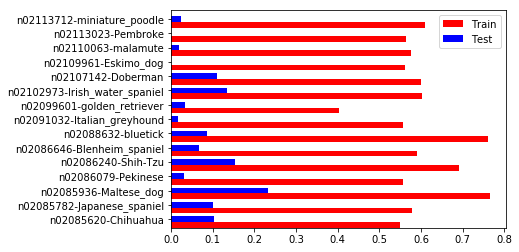

In [33]:
barh_results(y_encoded, score_train, score_test, encoder)